In [31]:
# @title
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
from PIL import Image as PILImage
from google.colab.output import eval_js
from base64 import b64encode, b64decode
from concurrent.futures import ThreadPoolExecutor
import time
import numpy as np
import io
from tqdm import tqdm
import requests
import json
import re

def img_to_b64(pil_img):
  buffer = io.BytesIO()
  pil_img.save(buffer, format="JPEG")
  return b64encode(buffer.getvalue()).decode('ascii')

def assert_ip(ip):
  m = re.search("^[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}$", ip)
  if m is None:
    raise ValueError("Invalid cluster IP")
  return ip

def take_photo(quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const countdown = document.createElement('div');
      countdown.textContent = 'Taking photo in: ';
      div.appendChild(countdown);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({
        video: { width: 400, height: 400 }
      });

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      for(let i = 3; i > 0; i--) {
        countdown.textContent = countdown.textContent += i.toString() + "... ";
        await new Promise((resolve) => setTimeout(resolve, 1000));
      }

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  imgdata = b64decode(data.split(',')[1])
  return PILImage.open(io.BytesIO(imgdata))

# Rock paper scissors classifier training and inference using GKE

This notebook serves as a foundation for "Deploying ML models on GKE" workshop.
- The first part contains code necessary to train and save the model.
- The second part focuses on running inference on GKE, experimenting with various endpoints and making sure deployment works.
- The third part performs a stress testing on deployed application to compare performance with GPU and autoscaler

## Training a model
This part of notebook focuses on training a CNN for classification of rock paper scissors hand positions.

The dataset home page: http://laurencemoroney.com/rock-paper-scissors-dataset

In [3]:
(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name='rock_paper_scissors',
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)
class_name = dataset_info.features['label'].int2str

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tmp/rock_paper_scissors/incomplete.7YPQVO_3.0.0/rock_paper_scissors-train.tfrecord*...:   0%|       …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling tmp/rock_paper_scissors/incomplete.7YPQVO_3.0.0/rock_paper_scissors-test.tfrecord*...:   0%|        …

Dataset rock_paper_scissors downloaded and prepared to tmp/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


Train/test length: 2520 372


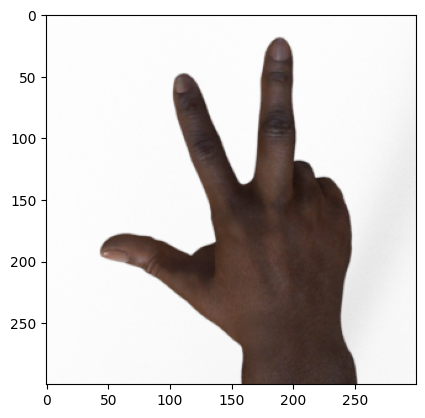

In [4]:
image, label = list(dataset_train_raw.take(1))[0]
print("Train/test length:", len(dataset_train_raw), len(dataset_test_raw))
plt.imshow(image)

After downloading a dataset, we are scaling all images from 300x300px to 224x224px as this is the resolution accepted by MobileNet.

In [5]:
dataset_train = dataset_train_raw.map(lambda x, y: (tf.image.resize(x, [224, 224]), y)) \
  .shuffle(buffer_size=100).repeat().batch(32)
dataset_test = dataset_test_raw.map(lambda x, y: (tf.image.resize(x, [224, 224]), y)) \
  .shuffle(buffer_size=100).repeat().batch(32)

Next, we using training a classifier on embeddings provided by MobileNet. To achieve that we are freezing the whole MobileNet and performing training on last layer only.

In [6]:
input = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.applications.mobilenet.preprocess_input(input)

x = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_tensor=x
)

for layer in x.layers:
  layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(x.output)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=[input], outputs=[x])

model.summary()

model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(
    dataset_train,
    epochs=5,
    steps_per_epoch=20,
    validation_data=dataset_test,
    validation_steps=3
)

<ipython-input-6-0b02b35c137d>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  x = tf.keras.applications.MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,231,939 (12.33 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.5562 - loss: 1.0360 - val_accuracy: 0.7500 - val_loss: 0.6396
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9490 - loss: 0.3665 - val_accuracy: 0.9062 - val_loss: 0.4320
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9859 - loss: 0.1956 - val_accuracy: 0.9688 - val_loss: 0.2738
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9954 - loss: 0.1233 - val_accuracy: 0.9375 - val_loss: 0.2631
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9952 - loss: 0.0991 - val_accuracy: 0.9271 - val_loss: 0.2341


The trained model performs well on given task and achieves 90%+ accuracy!

Now, we need to save the model to be able to deploy it to GKE. We are also enriching the model with additional layers providing decoding of base64 provided image, as we want to be able to send an image instead of pixels array.

In [ ]:
def get_serving_model(model):
  inputs = tf.keras.layers.Input(
      shape=(),
      dtype=tf.string,
      name='b64_input_bytes'
  )
  x = tf.keras.layers.Lambda(
      function=lambda input: tf.map_fn(
          lambda img_bytes: tf.image.resize(
              tf.image.decode_jpeg(img_bytes, channels=3),
              [224, 224]
          ),
          fn_output_signature=tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
          elems=input
      ),
      name='decode_image_bytes',
      output_shape=(224, 224, 3)
  )(inputs)
  x = model(x)
  return tf.keras.Model(inputs, x)

serving_model = get_serving_model(model)
serving_model.summary()
serving_model.export('rock_paper_scissors')

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ b64_input_bytes (InputLayer)    │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode_image_bytes (Lambda)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_8 (Functional)       │ (None, 3)              │     3,231,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,231,939 (12.33 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Saved artifact at 'rock_paper_scissors'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.string, name='b64_input_bytes')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138927902420112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927902414736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927902416848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927902418960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927902419152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927902421072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927902409168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927902421648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927902421456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927902419536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927902422800: Tens

Last step is to zip the bundle to be able to download it easily from colab.

In [ ]:
!zip -r rock_paper_scissors.zip rock_paper_scissors

  adding: rock_paper_scissors/ (stored 0%)
  adding: rock_paper_scissors/assets/ (stored 0%)
  adding: rock_paper_scissors/variables/ (stored 0%)
  adding: rock_paper_scissors/variables/variables.index (deflated 78%)
  adding: rock_paper_scissors/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: rock_paper_scissors/saved_model.pb (deflated 90%)
  adding: rock_paper_scissors/fingerprint.pb (stored 0%)


## Running an inference

**Before running this section, make sure you have completed step 01 from the repository.**

After successful deployment of the model, we can perform some inference tasks on it.
We start by specifying an IP address of our deployed service.

In [10]:
CLUSTER_IP = assert_ip("34.170.251.21")

Then, we can inspect model metadata. We can learn from it that it accepts multiple strings as an input. These are base64 strings meaning our additional layers for decoding them are working!

In [28]:
response = requests.get(f'http://{CLUSTER_IP}:8501/v1/models/rock_paper_scissors/metadata')
print(json.dumps(response.json(), indent=2))

{
  "model_spec": {
    "name": "rock_paper_scissors",
    "signature_name": "",
    "version": "1"
  },
  "metadata": {
    "signature_def": {
      "signature_def": {
        "__saved_model_init_op": {
          "inputs": {},
          "outputs": {
            "__saved_model_init_op": {
              "dtype": "DT_INVALID",
              "tensor_shape": {
                "dim": [],
                "unknown_rank": true
              },
              "name": "NoOp"
            }
          },
          "method_name": "",
          "defaults": {}
        },
        "serving_default": {
          "inputs": {
            "b64_input_bytes": {
              "dtype": "DT_STRING",
              "tensor_shape": {
                "dim": [
                  {
                    "size": "-1",
                    "name": ""
                  }
                ],
                "unknown_rank": false
              },
              "name": "serving_default_b64_input_bytes:0"
            }
          }

After seeing our server works and is ready to run inference queries, we need some picture for inference.

Let's take the picture of our hand then!

In [ ]:
pil_img = take_photo()
pil_img

I hope it looks nice! If not, you can re-run cell and take it again.

Now, let's call our API with that picture.

In [30]:
response = requests.post(
    f'http://{CLUSTER_IP}:8501/v1/models/rock_paper_scissors:predict',
    json = {
      "instances": [
          {
              "b64": img_to_b64(pil_img)
          }
      ]
    }
).json()
print(json.dumps(response, indent=2))

{
  "predictions": [
    [
      0.713404179,
      0.217596918,
      0.0689989
    ]
  ]
}


Let's decode that! Is the prediction correct?

In [17]:
prediction = class_name(np.argmax(response['predictions'][0]))
print(f"You showed {prediction}!")

You showed rock!


## Benchmarking inference

This section focuses on benchmarking our deployment and triggering autoscaling on GKE. We are sending a batch of previously taken picture and asking for prediciton many times. At the end we get a mean response time, its stddev and success percentage.

In [20]:
def benchmark(workers, calls, image, batch_size=10):
  input = json.dumps({
    "instances": [
        {
            "b64": img_to_b64(image)
        }
    ] * batch_size
  }).encode('ascii')

  def call_api(i):
    try:
      start = time.time()
      response = requests.post(
        f'http://{CLUSTER_IP}:8501/v1/models/rock_paper_scissors:predict',
        data=input,
        headers={"Content-Type": "application/json"}
      )
      return (i, time.time() - start)
    except:
      return (i, -1)

  with ThreadPoolExecutor(max_workers=workers) as executor:
      times = executor.map(call_api, list(range(calls)))
      results = []
      for i, t in tqdm(times, total=calls):
        results.append(t)
      results = np.array(results)
      results = results[results > 0]
      return (len(results) / calls, np.mean(results), np.std(results))

In [23]:
calls, mean, std = benchmark(workers=5, calls=500, image=pil_img)
print("Done!")
print("Successes", calls)
print("Mean", mean)
print("Std", std)

100%|██████████| 500/500 [01:31<00:00,  5.45it/s]

Done!
Successes 1.0
Mean 0.9162404613494873
Std 0.3578464086232382


# Experimenting with GPU

**This section requires step 02 to be completed from the repository**

Here, we are benchmarking our inference again. This time with GPU enabled. Do you see any difference?

In [25]:
calls, mean, std = benchmark(workers=5, calls=500, image=pil_img)
print("Done!")
print("Successes", calls)
print("Mean", mean)
print("Std", std)

100%|██████████| 500/500 [02:25<00:00,  3.45it/s]

Done!
Successes 0.994
Mean 1.4464661341078084
Std 0.6999580907439116
